# Move recommendations

In [187]:
import json
import random
import subprocess
import sys

import chess.engine
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [188]:
df = pd.read_parquet('data/moves_2025_01.parquet')
df.tail()

,avg_elo,moves,winner
4990819,1553.0,e2e4 d7d5 e4d5 d8d5 b1c3 d5e6 f1e2 b8c6 g1f3 g...,1
4990836,1960.0,e2e4 d7d5 e4d5 d8d5 d2d4 g8f6 c1e3 c8g4 f1e2 b...,1
4990890,817.5,e2e4 d7d5 e4d5 d8d5 d2d3 d5d4 c2c3 d4e5 f1e2 c...,2
4991060,1251.0,e2e4 d7d5 e4d5 d8d5 d2d4 g8f6 b1c3 g7g6 c3d5 f...,1
4991095,1889.5,e2e4 d7d5 e4d5 d8d5 g1f3 c8g4 f1e2 b8c6 e1g1 e...,1


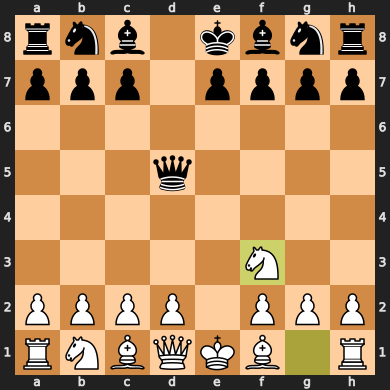

In [189]:
sample_row = df.sample(1).iloc[0]
moves_arr = sample_row['moves'].split()
cutoff = min(random.randint(5, len(moves_arr) - 1), 10)
moves = moves_arr[:cutoff]

board = chess.Board()
for uci in moves:
    board.push_uci(uci)

board

In [190]:
prefix = ' '.join(moves)
mask = df['moves'].str.startswith(prefix)

num_games = mask.sum()
num_white_wins = (df.loc[mask, 'winner'] == 1).sum()
winrate_white = num_white_wins / num_games if num_games > 0 else 0
avg_elo_current = int(df.loc[mask, 'avg_elo'].mean()) if num_games > 0 else 0

print(f"Times played: {num_games}")
print(f"Winrate in this position (white): {winrate_white:.2%}")
print(f"Average Elo of players: {avg_elo_current}")

Times played: 17865
Winrate in this position (white): 49.42%
Average Elo of players: 1706


In [191]:
results = []
for move in board.legal_moves:
    uci = move.uci()
    prefix2 = f"{prefix} {uci}"
    mask2 = df['moves'].str.startswith(prefix2)
    num = mask2.sum()
    if num > 0:
        wins = (df.loc[mask2, 'winner'] == 1).sum()
        winrate = wins / num
        elo_mean = int(df.loc[mask2, 'avg_elo'].mean())
    else:
        winrate, elo_mean = 0, 0
    results.append({
        'move': uci,
        'count': num,
        'winrate': winrate,
        'avg_elo': elo_mean
    })

df_next = (
    pd.DataFrame(results)
    .query("count > 1")
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

df_next

,move,count,winrate,avg_elo
0,d5d8,5792,0.493267,1773
1,c8g4,3946,0.473137,1743
2,g8f6,1927,0.506487,1680
3,d5e6,1516,0.511873,1537
4,d5a5,1181,0.455546,1763
5,b8c6,713,0.468443,1626
6,c8f5,502,0.527888,1655
7,d5d6,443,0.498871,1857
8,c7c6,343,0.501458,1770
9,d5e4,339,0.519174,1429


In [209]:
fen = board.fen()
moves = str(df_next['move'].tolist())

proc = subprocess.run(
    [sys.executable, 'evaluate_engine.py', fen, moves],
    capture_output=True,
    text=True
)

if proc.returncode != 0:
    raise RuntimeError(f"Engine script failed: {proc.stderr}")

engine_results = json.loads(proc.stdout)
engine_df = pd.DataFrame(engine_results)

df_stats = df_next.merge(engine_df, on='move')
df_stats

,move,count,winrate,avg_elo,delta,complexity
0,d5d8,5792,0.493267,1773,75,0.144089
1,c8g4,3946,0.473137,1743,23,0.184729
2,g8f6,1927,0.506487,1680,79,0.616995
3,d5e6,1516,0.511873,1537,144,0.295567
4,d5a5,1181,0.455546,1763,82,0.131773
5,b8c6,713,0.468443,1626,90,0.176108
6,c8f5,502,0.527888,1655,72,0.156404
7,d5d6,443,0.498871,1857,96,0.178571
8,c7c6,343,0.501458,1770,75,0.472906
9,d5e4,339,0.519174,1429,127,0.146552


In [198]:
proc2 = subprocess.run(
    [sys.executable, 'global_best.py', fen],
    capture_output=True,
    text=True
)

if proc.returncode != 0:
    raise RuntimeError(f"Engine script failed: {proc2.stderr}")

global_best_move = proc2.stdout
print("Global best move:", global_best_move)

Global best move: c8g4



## Cleaned winrate
* Mir ist aufgefallen, dass die Winrate so ja gar keinen Sinn macht, da es die Winrate für diese Elo sein muss, sonst weiß man ja nciht wie viel es bringt
* Komplexität und Bewertung des Zuges werden von der ELO ja nicht beeinflusst

In [214]:
ELO_DEVIATION = 0.30
min_elo = int(df["avg_elo"].min())
max_elo = int(df["avg_elo"].max())
sample_elos = random.sample(range(min_elo, max_elo + 1), 5)

for elo in sorted(sample_elos):
    low = elo * (1 - ELO_DEVIATION)
    high = elo * (1 + ELO_DEVIATION)

    for idx, move in df_stats.iterrows():
        uci = move['move']
        prefix2 = f"{prefix} {uci}"

        mask = df['moves'].str.startswith(prefix2)
        mask &= df['avg_elo'].between(low, high)

        num = mask.sum()
        if num > 0:
            wins = (df.loc[mask, 'winner'] == 1).sum()
            winrate = wins / num
        else:
            winrate = 0.0

        df_stats.at[idx, 'winrate'] = winrate

    COMPLEXITY_WEIGHT = max(0.0, 0.4 - (elo - 1000) / 2000)
    RATING_WEIGHT = 0.35
    HISTORICAL_WEIGHT = 1 - RATING_WEIGHT - COMPLEXITY_WEIGHT

    scaler = MinMaxScaler()
    df_stats['delta_scaled'] = scaler.fit_transform(df_stats[['delta']])

    df_stats['score'] = (
        RATING_WEIGHT * df_stats['delta_scaled'] +
        COMPLEXITY_WEIGHT * (1 - df_stats['complexity']) +
        HISTORICAL_WEIGHT * df_stats['winrate']
    )

    df_score = df_stats.sort_values("score", ascending=False)
    print("Best move for elo",elo,":", df_score['move'].iloc[0])

Best move for elo 1266 : d5d4
Best move for elo 1620 : d5d4
Best move for elo 1810 : d5d2
Best move for elo 2309 : d5d2
Best move for elo 2872 : d5e5


In [213]:
elo = 1200
COMPLEXITY_WEIGHT = max(0.0, 0.5 - (elo - 1000) / 2000)
RATING_WEIGHT = 0.25
HISTORICAL_WEIGHT = 1 - RATING_WEIGHT - COMPLEXITY_WEIGHT

scaler = MinMaxScaler()
df_stats['delta_scaled'] = scaler.fit_transform(df_stats[['delta']])

# Berechnung des Scores
df_stats['score'] = (
    RATING_WEIGHT * df_stats['delta_scaled'] +
    COMPLEXITY_WEIGHT * (1 - df_stats['complexity']) +
    HISTORICAL_WEIGHT * df_stats['winrate']
)

df_score = df_stats.sort_values("score", ascending=False)
df_score

,move,count,winrate,avg_elo,delta,complexity,delta_scaled,score
29,d5a2,4,1.000000,1974,699,0.146825,0.964337,0.932354
31,d5d2,3,1.000000,1337,711,0.211640,0.981455,0.910708
32,d5b5,3,0.666667,1843,724,0.323892,1.000000,0.753777
16,d5e5,50,0.500000,1457,717,0.203202,0.990014,0.741223
17,f7f6,38,1.000000,1327,157,0.163793,0.191155,0.732272
21,d5f3,25,0.538462,1879,520,0.140212,0.708987,0.709624
33,c8d7,2,1.000000,1904,123,0.205665,0.142653,0.703397
19,b7b6,35,0.666667,1495,155,0.163793,0.188302,0.614892
10,e7e5,330,0.712121,1430,113,0.167488,0.128388,0.614344
13,d5h5,60,0.655172,1620,140,0.157635,0.166904,0.607982


### Todo
* Anstatt Winrate sollte man winrate für eine Elo-Stufe mit Abweichung 10% z.B. nehmen
* Problem: Sind das zu wenige Faktoren? Gefühlt nimmt man halt immer den besten zug und je nach elo einen etwas leichteren